In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import gzip, csv
import time, math
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# 超参数设置Parameters
Hidden_size = 100
Batch_size = 256
Num_layers = 2
Num_epochs = 10
Num_charts = 128 # ASCII码字符数量
Use_gpu = True
Epochs = 100
Learning_rate = 0.001

In [3]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

1. 准备数据集

In [4]:
# 编写一个数据集类，用于读取数据
class NamesDataset(Dataset):
    def __init__(self, is_train_set=True):
        # 因为数据量不多，可以一次性把名字数据集全部读入内存
        filename = '../data/names_train.csv.gz' if is_train_set else '../data/names_test.csv.gz'
        
        # 使用csv模块读取压缩文件
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader) # 把所有行读到一个列表中

        # 名字在第一列，所以是row[0]
        self.names = [row[0] for row in rows] 
        # 有多少个名字
        self.len = len(self.names) 
        # 而国家在第二列，所以row[1]
        self.countries = [row[1] for row in rows]
        # 把所有国家取出来，然后排序，（用集合）去重=》每个国家只有一个实例 
        self.country_list = list(sorted(set(self.countries))) 
        # 把国家转成词典，方便找国家对应的索引数值是多少（在getitem中用）
        self.country_dict = self.getCountryDict()
        # 一共有多少个国家
        self.country_num = len(self.country_list) 
        
    # 数据集索引访问
    # 输入：索引
    # 输出：名字、国家
    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]

    # 数据集长度
    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()
        # 遍历国家列表，把每个国家和对应的索引放进字典中
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict # 返回字典

    # 以下两个函数作用是便于显示：
    # 把索引转成国家名称
    def idx2country(self, index):
        return self.country_list[index]
    # 获取国家的数量
    def getCountriesNum(self):
        return self.country_num

In [5]:
train_set = NamesDataset(is_train_set=True)
test_set = NamesDataset(is_train_set=False)
TrainLoader = DataLoader(train_set, batch_size=Batch_size, shuffle=True)
TestLoader = DataLoader(test_set, batch_size=Batch_size, shuffle=False)

# 决定了最后模型输出的维度
Country_Number = train_set.getCountriesNum()

2. 设计模型

双向Bi-Direction RNN/LSTM/GRU  
    <br>既要考虑之前的输入，还要考虑之后的输入。
    <br>所以正向和反向的RNN/LSTM/GRU都要计算。
    <br>最后正向和反向的hidden输出结果h(forward)和h(backward)拼接concat起来作为最终的输出。

In [6]:
# 判定是否使用GPU
def use_gpu_tensors(tensor):
    if Use_gpu:
        # 如果使用GPU，将张量转换成GPU张量
        device = torch.device("cuda")
        tensor = tensor.to(device)
    return tensor

In [7]:
# 设计一个RNN分类器
class RNNClassifier(nn.Module):
    # bidirectional=True表示使用双向GRU
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 用2表示双向GRU，用1表示单向GRU
        self.num_directions = 2 if bidirectional else 1

        # Emebedding layer的输入维度是(seq_len, batch_size)
        # 输出维度是(seq_len, batch_size, hidden_size)  
        self.embedding = nn.Embedding(input_size, hidden_size)
        # （GRU的输入维度和输出维度都为hidden_size）
        # GRU层的数据输入维度为(seq_len, batch_size, hidden_size)
        # 隐藏层输入维度为(num_layers*num_directions, batch_size, hidden_size)
        # 数据输出维度为(seq_len, batch_size, num_directions*hidden_size)
        # 隐藏层输出维度为(num_layers*num_directions, batch_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, bidirectional=bidirectional)

        # 全连接层的输入维度为(seq_len, batch_size, num_directions*hidden_size)
        # 输出维度为(seq_len, batch_size, output_size)
        # 因为是双向的，所以要乘以2
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
        
     # 初始化全为0的隐藏层
     # 维度为(num_layers*num_directions, batch_size, hidden_size)   
    def _init_hidden(self, batch_size):  
        hidden = torch.zeros(self.num_layers * self.num_directions,
                             batch_size, self.hidden_size)
        return use_gpu_tensors(hidden)

    def forward(self, input, seq_lengths):
        # 输入维度为B x S，转置后输入维度为S x B（满足embedding层输入的需要）
        # 将横着的数据变成竖着的
        input = input.t()
        batch_size = input.size(1) # 输入的batch_size保存，便于初始化隐藏层

        # 初始化隐藏层
        hidden = self._init_hidden(batch_size)
        # 让输入数据通过embedding层
        # 输入维度为(S, B)，输出维度为(S, B, hidden_size)
        embedding  = self.embedding(input)

        # 因为padding部分都是0，需要pack一下，让RNN不要去处理0，提高效率
        # seq_lengths is already on CPU, so we don't need to move it
        gru_input = nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)

        # 让输入数据通过GRU层
        # (***)hidden的输出维度为为(num_layers*num_directions, batch_size, hidden_size)
        # output的输出维度为(S, B, num_directions*hidden_size)
        output, hidden = self.gru(gru_input, hidden)

        if self.num_directions == 2:
            # 因为是双向的，所以要将两个方向的输出拼接起来
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            # 单向的话，直接取最后一层的输出
            hidden_cat = hidden[-1]

        # 让输出数据通过全连接层
        fc_output = self.fc(hidden_cat)
        return fc_output

In [8]:
# 将名字转换成ASCII码列表
def name2list(name):
    # 先将名字通过ord函数转换成ASCII码
    arr = [ord(c) for c in name]
    # 返回一个元组，第一个元素是ASCII码列表，第二个元素是列表的长度
    return arr, len(arr)

In [9]:
# 将名字列表转换成张量
def make_tensor(names, countries):
    # 取出ASCII码列表和列表长度，组成一个个元组，这些元组组成一个新的列表
    sequences_and_lengths = [name2list(name) for name in names]
    # 遍历sequences_and_lengths中的每个元组，取出第一个元素，组成一个新的列表=>名字的ASCII码列表
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    # 遍历sequences_and_lengths中的每个元组，取出第二个元素，组成一个新的列表=>名字的长度列表
    # 使用torch.LongTensor将列表转换成张量
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    # 因为是ASCII码，所以数据类型是long
    countries = countries.long()

    # 因为每个名字的长度都是不一样的，所以需要将名字的长度补齐,补齐的位置用0填充
    # 补齐的长度为max_seq_length，也就是列表中的最大值
    # 此处的做法是先创建一个全0的张量，然后再将名字的ASCII码列表覆盖到张量中
    #   1. 使用torch.zeros创建一个全0的张量，维度为(Batch_size, max_seq_length) 
    seq_tensor = torch.zeros(len(name_sequences), int(seq_lengths.max())).long()
    #   2. 使用for循环遍历name_sequences中的每个名字的ASCII码列表
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        #   3. 将名字的ASCII码列表覆盖到张量中
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        
    # 排序，返回排序后的张量，排序前的索引，以及排序前的维度
    # 此处的排序是按照名字的长度从大到小排序
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    # 按照排序后的索引，将张量中的数据重新排序
    seq_tensor = seq_tensor[perm_idx]
    # 按照排序后的索引，将国家的列表中的数据重新排序
    countries = countries[perm_idx]
    
    return use_gpu_tensors(seq_tensor), seq_lengths, use_gpu_tensors(countries)

3. 训练模型

In [10]:
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(TrainLoader, 1):
        inputs, seq_lengths, targets = make_tensor(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            # 需要先导入time模块
            print(f'[{time_since(start)}] Epoch {epoch}', end='')
            print(f"[{i * len(inputs)}/{len(TrainLoader)}]", end='')
            print(f", Loss {total_loss / (i * len(inputs))}")
    return total_loss

In [11]:
def testModel():
    correct = 0
    total = len(test_set)
    with torch.no_grad():
        for i, (names, countries) in enumerate(TestLoader, 1):
            inputs, seq_lengths, labels = make_tensor(names, countries)
            outputs = classifier(inputs, seq_lengths)
            pred = outputs.max(dim=1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
    percent = '%.2f' % (100 * correct / total)
    print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct / total

In [12]:
if __name__ == '__main__':
    classifier = RNNClassifier(Num_charts, Hidden_size, Country_Number, Num_layers)
    if Use_gpu:
        device = torch.device('cuda')
        classifier.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=Learning_rate)

    start = time.time()
    print('Training for %d epochs...' % Epochs)
    acc_list = []
    for epoch in range(1, Epochs + 1):
        trainModel()
        acc = testModel()
        acc_list.append(acc)

Training for 100 epochs...
 0s] Epoch 1[2560/53], Loss 0.008754618372768164
 1s] Epoch 1[5120/53], Loss 0.007615089952014387
 1s] Epoch 1[7680/53], Loss 0.006938202011709412
 1s] Epoch 1[10240/53], Loss 0.00647361947922036
 2s] Epoch 1[12800/53], Loss 0.006118286550045014
Test set: Accuracy 4449/6700 66.40%
 3s] Epoch 2[2560/53], Loss 0.0042278452310711145
 3s] Epoch 2[5120/53], Loss 0.004176249797455967
 4s] Epoch 2[7680/53], Loss 0.004035061543496947
 4s] Epoch 2[10240/53], Loss 0.003958184423390776
 4s] Epoch 2[12800/53], Loss 0.0038815273251384497
Test set: Accuracy 4879/6700 72.82%
 6s] Epoch 3[2560/53], Loss 0.0033358655869960784
 7s] Epoch 3[5120/53], Loss 0.003201750828884542
 8s] Epoch 3[7680/53], Loss 0.0031450104899704455
 8s] Epoch 3[10240/53], Loss 0.0031116365105845036
 9s] Epoch 3[12800/53], Loss 0.0030668044183403253
Test set: Accuracy 5210/6700 77.76%
 11s] Epoch 4[2560/53], Loss 0.0028361104894429447
 11s] Epoch 4[5120/53], Loss 0.002752698410768062
 12s] Epoch 4[7680

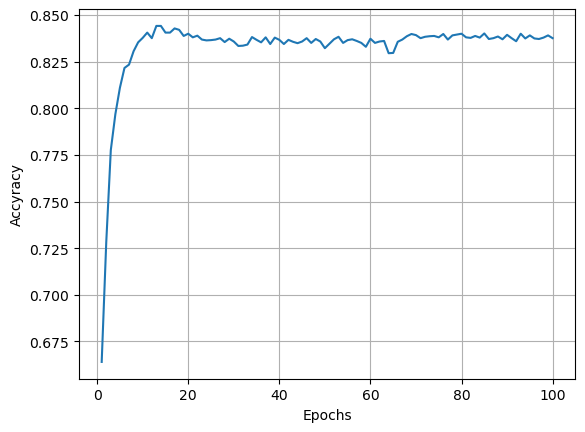

In [13]:
Epochs = np.arange(1, len(acc_list) + 1, 1)
acc_list = np.array(acc_list)
plt.plot(Epochs, acc_list)
plt.xlabel('Epochs')
plt.ylabel('Accyracy')
plt.grid()
plt.show()